In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import time

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [3]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images))
print(images.shape)
print(labels.shape)

def show_images (images , labels):
    fig = plt.figure()
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(images[i][0], cmap='gray')
        #print(images[i][0].shape)
        plt.title("Original Truth Label: {}".format(labels[i]))
        plt.yticks([])
        plt.xticks([])
    plt.show()

def show_image (image , label):
    
    plt.imshow(image, cmap='gray')
    #print(images[i][0].shape)
    #plt.title("Original Truth Label: {}".format(label[i]))
    plt.yticks([])
    plt.xticks([])
    plt.show()

#show_image(images[0] , labels[0])  


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension, device=device)

In [5]:
class Discriminator(nn.Module):
    def __init__(self,
                 image_dimension=784,
                 hidden_dimension=128):
        super().__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, 256),
            nn.Dropout(0.5),
            self.discriminator_block(256, 128),
            nn.Dropout(0.5),
            self.discriminator_block(128, 64),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [6]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=100,
                       image_dimension=784,
                       hidden_dimension=128):
        super().__init__()

        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, 512),
            self.generator_block(512, 256),
            self.generator_block(256, self.h_dim),
            #self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim, self.im_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise)

    # Simple neural network single block
    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.LeakyReLU(0.2,inplace=True),
        )

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            fake_noise = get_noise(num_samples, self.n_dim, device=device)
            fake = self.forward(fake_noise)
        # Return the generated samples
        return fake

In [7]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred,
                               torch.zeros_like(disc_fake_pred))

    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # But all of them will got label as 1
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
display_step = 50
noise_dimension = 64

In [9]:
def train(disc, gen, batch_size=64, learning_rate=1e-5, num_epochs=50):


  # Define the loss function
  criterion = nn.BCEWithLogitsLoss()

  gen_opt = torch.optim.Adam(gen.parameters(), lr=learning_rate)
  disc_opt = torch.optim.Adam(disc.parameters(), lr=learning_rate)


  # Set the device to GPU if available, otherwise use CPU
  disc.to(device)
  gen.to(device)

  trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

  disc.train()
  gen.train()

  cur_step = 0
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  gen_loss = False

  for epoch in range(num_epochs):
      for batch_idx, (real, labels) in enumerate (trainLoader):

          # Get number of batch size (number of image)
          # And get tensor for each image in batch
          cur_batch_size = len(real)
          real = real.view(cur_batch_size, -1).to(device)


          ### Traing discriminator ###
          # Zero out the gradient .zero_grad()
          # Calculate discriminator loss get_disc_loss()
          # Update gradient .gradient()
          # Update optimizer .step()
          disc_opt.zero_grad()
          disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
          disc_loss.backward(retain_graph=True)
          disc_opt.step()

          ### Traing generator ###
          # Zero out the gradient .zero_grad()
          # Calculate discriminator loss get_gen_loss()
          # Update gradient .gradient()
          # Update optimizer .step()
          gen_opt.zero_grad()
          gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
          gen_loss.backward()
          gen_opt.step()

          mean_discriminator_loss += disc_loss.item() / display_step
          mean_generator_loss += gen_loss.item() / display_step

          if cur_step % display_step == 0 and cur_step > 0:
              print(f"Epoch {cur_step/len(trainLoader)}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
              mean_generator_loss = 0
              mean_discriminator_loss = 0

          cur_step += 1

In [10]:
def sample_gan(generator, num_samples=1):
  generator.eval()
  
  decoded = generator.sample(num_samples).reshape(28,28).cpu()

  show_image(decoded, label=None)

In [11]:
gen = Generator(noise_dimension)
disc = Discriminator()

train(disc, gen,batch_size=100, learning_rate=1e-5, num_epochs=30)

Epoch 0.053304904051172705: Generator loss: 0.478069983124733, discriminator loss: 0.7377901780605316
Epoch 0.10660980810234541: Generator loss: 0.46931652009487146, discriminator loss: 0.7181068480014802
Epoch 0.15991471215351813: Generator loss: 0.47003367781639105, discriminator loss: 0.7116184902191162
Epoch 0.21321961620469082: Generator loss: 0.47071143150329603, discriminator loss: 0.7031015825271605
Epoch 0.26652452025586354: Generator loss: 0.47079124510288245, discriminator loss: 0.6940336096286776
Epoch 0.31982942430703626: Generator loss: 0.47102888464927684, discriminator loss: 0.6848856878280637
Epoch 0.373134328358209: Generator loss: 0.4701673126220705, discriminator loss: 0.6784434700012206
Epoch 0.42643923240938164: Generator loss: 0.46882053732872, discriminator loss: 0.673573831319809
Epoch 0.47974413646055436: Generator loss: 0.4678182578086854, discriminator loss: 0.6711584913730622
Epoch 0.5330490405117271: Generator loss: 0.46777709186077115, discriminator loss:

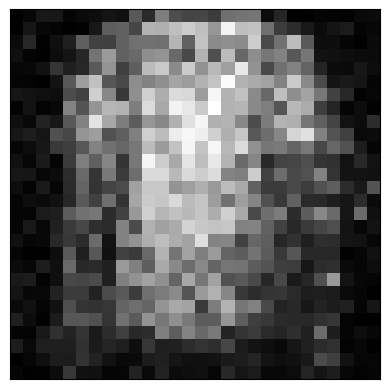

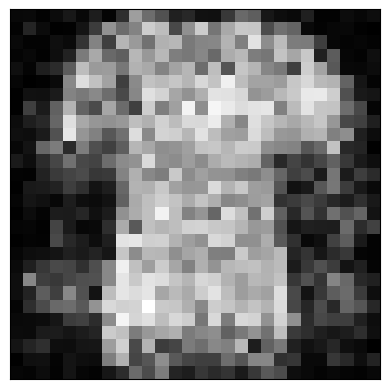

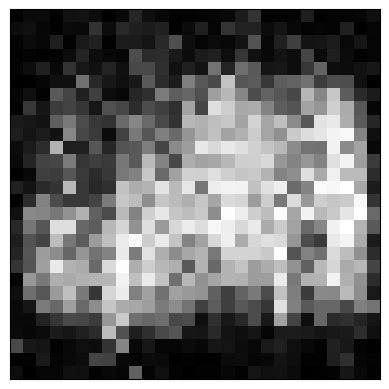

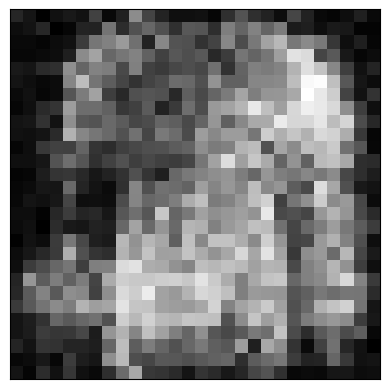

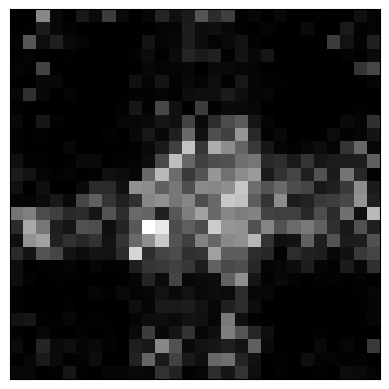

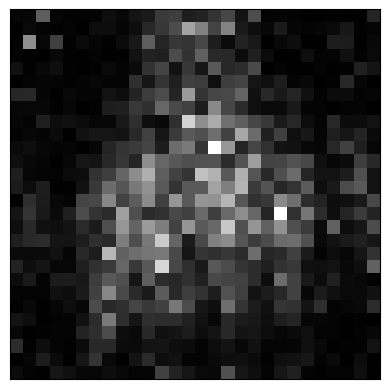

In [12]:
for i in range(6):
    sample_gan(gen.to(device), num_samples=1)

## with CNN

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=100, hidden_dimension=128):
        super(Generator, self).__init__()
 
        self.n_dim = noise_dimension
        self.h_dim = hidden_dimension
 
        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(self.n_dim, self.init_size * self.init_size * self.h_dim))
 
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(self.h_dim),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim, self.h_dim // 2, 3, stride=1, padding=1),
            nn.BatchNorm2d(self.h_dim // 2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(self.h_dim // 2, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )
 
    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], self.h_dim, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
 
        self.disc = nn.Sequential(
            # Convolutional layer taking in 1 input channel (image), outputting 64 channels
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),  # 'same' padding in PyTorch is achieved with padding=2 for a 5x5 kernel
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout(0.5),
 
            # Second convolutional layer, 64 input channels, 128 output channels
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout(0.5),
 
            # Flatten the output for the dense layer
            nn.Flatten(),
 
            # Final dense layer to get to 1 output
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        return self.disc(x)

In [15]:
discriminator = Discriminator()
generator = Generator()

In [16]:
# Training settings
num_epochs = 50  # Number of epochs to train for
batch_size = 64  # Batch size
noise_dimension = 100  # Dimension of the noise vector
data_loader = trainLoader
# Define optimizers for both generator and discriminator
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
 
# Binary cross-entropy loss
criterion = nn.BCELoss()
# Placeholder for logging
losses = []
 
# Main training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):  # Assuming data_loader is defined elsewhere and loads images
        # Reshape and normalize the images
        images = images.reshape(images.size(0), -1)
        # Train discriminator with real images
        discriminator.zero_grad()
        real_labels = torch.ones(images.size(0), 1)
        real_loss = criterion(discriminator(images), real_labels)
        real_loss.backward()
 
        # Train discriminator with fake images
        noise = torch.randn(batch_size, noise_dimension)
        fake_images = generator(noise)
        fake_labels = torch.zeros(fake_images.size(0), 1)
        fake_loss = criterion(discriminator(fake_images.detach()), fake_labels)
        fake_loss.backward()
        optimizer_discriminator.step()
 
        # Train generator
        generator.zero_grad()
        fake_labels = torch.ones(fake_images.size(0), 1)  # The generator's goal is to have the discriminator label these as real
        gen_loss = criterion(discriminator(fake_images), fake_labels)
        gen_loss.backward()
        optimizer_generator.step()
 
        # Logging and statistics
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], D_loss: {real_loss.item() + fake_loss.item()}, G_loss: {gen_loss.item()}")
            losses.append((real_loss.item() + fake_loss.item(), gen_loss.item()))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

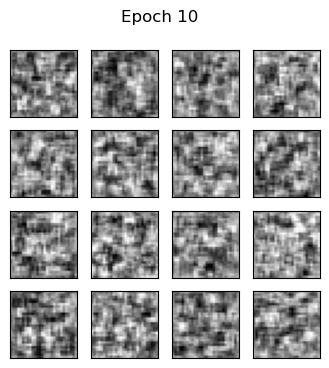

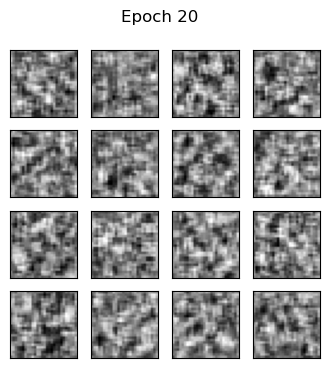

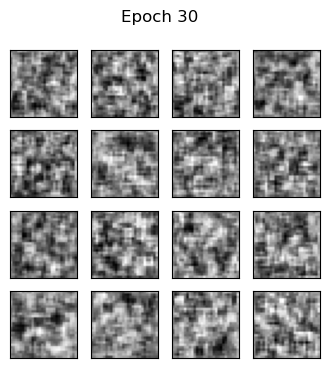

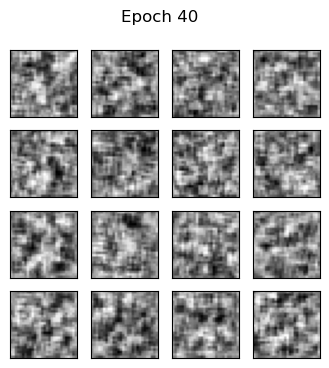

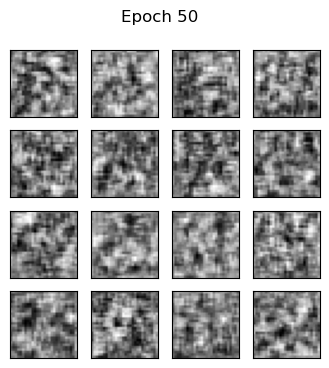

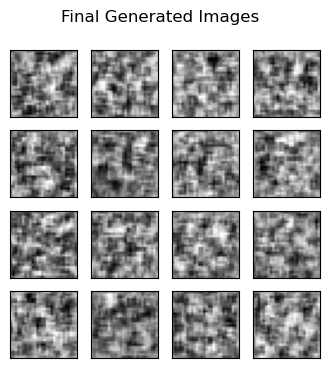

In [17]:
import matplotlib.pyplot as plt
import numpy as np
 
# Function to create a grid of generated images
def show_generated_images(generator, noise_dimension, num_images=16, title=""):
    noise = torch.randn(num_images, noise_dimension)
    generated_images = generator(noise).detach().cpu().numpy()
    generated_images = np.reshape(generated_images, newshape=(-1, 28, 28))  # Adjust shape depending on your image dimensions
    fig, axes = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), generated_images):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img, cmap='gray')
    plt.suptitle(title)
    plt.show()
 
# Main training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Train discriminator and generator as before
 
        # Visualization: Every 'n' epochs, generate and show images to track the progress
        if (epoch + 1) % 10 == 0 and i == len(data_loader) - 1:  # Adjust the frequency of image generation
            show_generated_images(generator, noise_dimension, title=f"Epoch {epoch + 1}")
 
# Generate and show images after training is complete
show_generated_images(generator, noise_dimension, title="Final Generated Images")

Epoch [1/50], Step [100/938], D_loss: 0.15152647346258163, G_loss: 3.277090072631836
Epoch [1/50], Step [200/938], D_loss: 1.1139790415763855, G_loss: 1.2501362562179565
Epoch [1/50], Step [300/938], D_loss: 0.5803957879543304, G_loss: 2.1630775928497314
Epoch [1/50], Step [400/938], D_loss: 0.6340598165988922, G_loss: 2.255502223968506
Epoch [1/50], Step [500/938], D_loss: 1.6704419255256653, G_loss: 0.8018456697463989
Epoch [1/50], Step [600/938], D_loss: 0.4808034598827362, G_loss: 2.3770031929016113
Epoch [1/50], Step [700/938], D_loss: 0.5279086530208588, G_loss: 1.9397815465927124
Epoch [1/50], Step [800/938], D_loss: 0.7425439059734344, G_loss: 1.8664690256118774
Epoch [1/50], Step [900/938], D_loss: 0.6724342703819275, G_loss: 3.1287970542907715
Epoch [2/50], Step [100/938], D_loss: 0.3485155999660492, G_loss: 2.669013261795044
Epoch [2/50], Step [200/938], D_loss: 0.20433546602725983, G_loss: 3.575040578842163
Epoch [2/50], Step [300/938], D_loss: 0.32613222301006317, G_loss: 

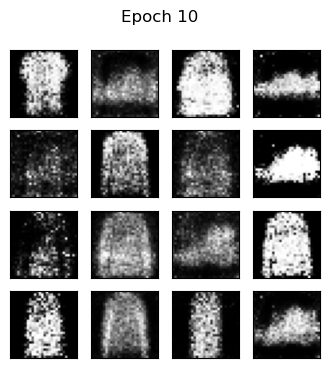

Epoch [11/50], Step [100/938], D_loss: 1.153881996870041, G_loss: 1.2872653007507324
Epoch [11/50], Step [200/938], D_loss: 1.0914947390556335, G_loss: 1.367395043373108
Epoch [11/50], Step [300/938], D_loss: 0.853250652551651, G_loss: 1.405219316482544
Epoch [11/50], Step [400/938], D_loss: 1.260134220123291, G_loss: 1.0425840616226196
Epoch [11/50], Step [500/938], D_loss: 1.1543346345424652, G_loss: 1.51908540725708
Epoch [11/50], Step [600/938], D_loss: 0.9124694168567657, G_loss: 1.5496678352355957
Epoch [11/50], Step [700/938], D_loss: 0.8885749578475952, G_loss: 1.4376285076141357
Epoch [11/50], Step [800/938], D_loss: 0.7938844263553619, G_loss: 1.6302789449691772
Epoch [11/50], Step [900/938], D_loss: 1.1675907373428345, G_loss: 1.5637037754058838
Epoch [12/50], Step [100/938], D_loss: 1.038572371006012, G_loss: 1.1464128494262695
Epoch [12/50], Step [200/938], D_loss: 1.1062493920326233, G_loss: 1.197559118270874
Epoch [12/50], Step [300/938], D_loss: 1.1439284682273865, G_lo

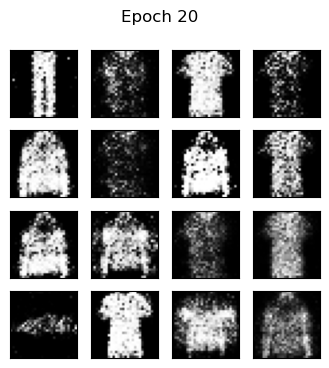

Epoch [21/50], Step [100/938], D_loss: 1.2194700241088867, G_loss: 1.4154468774795532
Epoch [21/50], Step [200/938], D_loss: 1.1320533156394958, G_loss: 1.0350356101989746
Epoch [21/50], Step [300/938], D_loss: 1.0543238818645477, G_loss: 1.2564680576324463
Epoch [21/50], Step [400/938], D_loss: 1.039798527956009, G_loss: 1.160198450088501
Epoch [21/50], Step [500/938], D_loss: 1.1544384360313416, G_loss: 1.395756721496582
Epoch [21/50], Step [600/938], D_loss: 1.3154359459877014, G_loss: 1.0231032371520996
Epoch [21/50], Step [700/938], D_loss: 1.105546772480011, G_loss: 1.3608739376068115
Epoch [21/50], Step [800/938], D_loss: 1.0802857279777527, G_loss: 1.2128002643585205
Epoch [21/50], Step [900/938], D_loss: 1.0780706405639648, G_loss: 1.4533817768096924
Epoch [22/50], Step [100/938], D_loss: 0.9591518640518188, G_loss: 1.395953893661499
Epoch [22/50], Step [200/938], D_loss: 1.1723501086235046, G_loss: 1.2619154453277588
Epoch [22/50], Step [300/938], D_loss: 0.9877554178237915, 

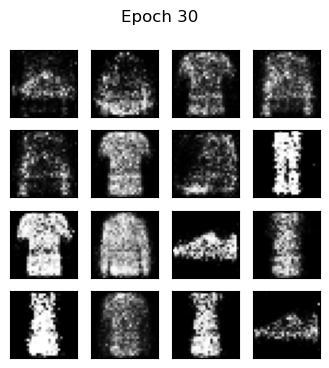

Epoch [31/50], Step [100/938], D_loss: 1.0679609179496765, G_loss: 1.2252860069274902
Epoch [31/50], Step [200/938], D_loss: 0.9956234693527222, G_loss: 1.0436855554580688
Epoch [31/50], Step [300/938], D_loss: 1.0260657370090485, G_loss: 1.3680776357650757
Epoch [31/50], Step [400/938], D_loss: 1.0781177878379822, G_loss: 1.3498808145523071
Epoch [31/50], Step [500/938], D_loss: 0.9208414852619171, G_loss: 1.2875051498413086
Epoch [31/50], Step [600/938], D_loss: 1.3495622873306274, G_loss: 1.2929686307907104
Epoch [31/50], Step [700/938], D_loss: 1.0294153690338135, G_loss: 1.3287547826766968
Epoch [31/50], Step [800/938], D_loss: 1.2803858518600464, G_loss: 1.140087604522705
Epoch [31/50], Step [900/938], D_loss: 1.2000874876976013, G_loss: 1.0862332582473755
Epoch [32/50], Step [100/938], D_loss: 1.6605033874511719, G_loss: 0.9134096503257751
Epoch [32/50], Step [200/938], D_loss: 0.9676857590675354, G_loss: 1.2155439853668213
Epoch [32/50], Step [300/938], D_loss: 1.27730494737625

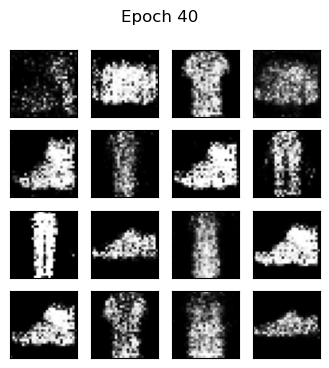

Epoch [41/50], Step [100/938], D_loss: 1.4175298810005188, G_loss: 0.9856414794921875
Epoch [41/50], Step [200/938], D_loss: 1.214990496635437, G_loss: 0.9516384601593018
Epoch [41/50], Step [300/938], D_loss: 1.3685537576675415, G_loss: 1.2419230937957764
Epoch [41/50], Step [400/938], D_loss: 1.1822083592414856, G_loss: 0.9273191690444946
Epoch [41/50], Step [500/938], D_loss: 1.063225507736206, G_loss: 1.2740399837493896
Epoch [41/50], Step [600/938], D_loss: 1.2726508378982544, G_loss: 1.1988987922668457
Epoch [41/50], Step [700/938], D_loss: 0.950724184513092, G_loss: 1.1677885055541992
Epoch [41/50], Step [800/938], D_loss: 1.2688664197921753, G_loss: 1.1728392839431763
Epoch [41/50], Step [900/938], D_loss: 1.0398346781730652, G_loss: 1.0768855810165405
Epoch [42/50], Step [100/938], D_loss: 1.2321996688842773, G_loss: 1.0987756252288818
Epoch [42/50], Step [200/938], D_loss: 1.1203540563583374, G_loss: 1.2348816394805908
Epoch [42/50], Step [300/938], D_loss: 1.1775475144386292

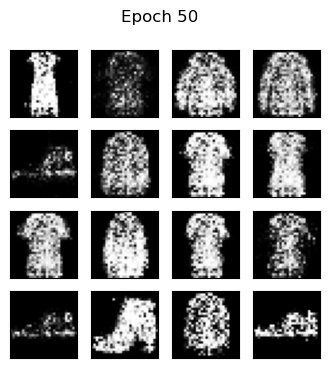

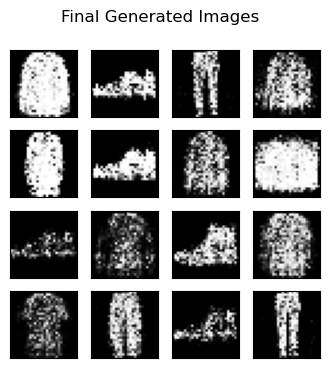

In [18]:
data_loader = trainLoader
# Generator definition

class Generator(nn.Module):

    def __init__(self, noise_dimension=100):

        super(Generator, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(noise_dimension, 256),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 784),

            nn.Tanh(),

        )
 
    def forward(self, z):

        return self.model(z).view(-1, 1, 28, 28)
 
# Discriminator definition

class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(

            nn.Linear(784, 512),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),

            nn.Sigmoid(),

        )
 
    def forward(self, img):

        flattened = img.view(img.size(0), -1)

        return self.model(flattened)
 
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)
 
# Optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)
 
# Loss function
criterion = nn.BCELoss()
 
# Number of epochs and noise dimension
n_epochs = 50
noise_dim = 100
 
# Function to visualize generated images
def show_generated_images(generator, noise_dimension, num_images=16, title=""):
    noise = torch.randn(num_images, noise_dimension, device=device)
    with torch.no_grad():
        generated_images = generator(noise).cpu().numpy()
    generated_images = np.reshape(generated_images, newshape=(-1, 28, 28))
    fig, axes = plt.subplots(4, 4, figsize=(4, 4), sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), generated_images):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img.squeeze(), cmap='gray')
    plt.suptitle(title)
    plt.show()
 
# Training loop
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(trainLoader):
 
        # Move images to the appropriate device
        imgs = imgs.to(device)
 
        # Train Discriminator
        optimizer_D.zero_grad()
 
        real_labels = torch.ones(imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(imgs.size(0), 1, device=device)
 
        real_loss = criterion(discriminator(imgs), real_labels)
        real_loss.backward()
 
        noise = torch.randn(imgs.size(0), noise_dim, device=device)
        fake_imgs = generator(noise).detach()
        fake_loss = criterion(discriminator(fake_imgs), fake_labels)
        fake_loss.backward()
 
        optimizer_D.step()
 
        # Train Generator
        optimizer_G.zero_grad()
 
        gen_labels = torch.ones(imgs.size(0), 1, device=device)
        loss_G = criterion(discriminator(generator(noise)), gen_labels)
        loss_G.backward()
 
        optimizer_G.step()
 
        # Logging
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(trainLoader)}], D_loss: {real_loss.item() + fake_loss.item()}, G_loss: {loss_G.item()}")
 
    # Visualize images periodically
    if (epoch + 1) % 10 == 0:
        show_generated_images(generator, noise_dim, title=f"Epoch {epoch + 1}")
 
# Final visualization
show_generated_images(generator, noise_dim, title="Final Generated Images")
